In [78]:
import pandas as pd
import json
from globals import BASE_DIR
import os
import matplotlib.pyplot as plt
import random
from postprocess_baseline_top_k import dataset_metadata
from evaluation_metrics import ndcg, calculate_arp_poplift, evaluation_user_group_means

top_k_eval = 10

available_datasets = ["brightkite", "foursquaretky", "gowalla", "snowcard", "yelp"]

dataset = "brightkite"

#valid_popularity = "business_popularity:float"
valid_popularity = "item_pop"
recommendation_dirpart = "recommendations"

In [79]:
def process_top_k_json(input_file, output_file, k=10):
    """
    Process top-k recommendations from a JSON file, keeping only the item IDs for each user.

    Args:
    - input_file (str): Path to the original JSON file.
    - output_file (str): Path to save the processed JSON file.
    - k (int): Number of top-k recommendations to keep per user.
    """
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    try:
        with open(input_file, 'r') as infile:
            data = json.load(infile)

        top_k_result = {}
        for user_id, recommendations in data.items():
            if recommendations and isinstance(recommendations[0], dict):
                item_ids = recommendations[0]["item_id"][:k]
                top_k_result[user_id] = item_ids

        with open(output_file, 'w') as outfile:
            json.dump(top_k_result, outfile, indent=4)
        print(f"Processed file saved to: {output_file}")
    
    except Exception as e:
        print(f"Error processing {input_file}: {e}")

In [80]:
def create_model_directories(dataset, data, base_dir, recommendation_dirpart):
    model_directories = {}
    methods = ["baseline", "cp", "cp_min_js", "upd"]

    def recommender_dir_combiner(dataset, modelpart, method):
        return f"{base_dir}{dataset}_dataset/{recommendation_dirpart}/{modelpart}/{method + '/'}top_k_recommendations.json"

    for result in data:
        model_name = result["model"]
        model_directories[model_name] = {}
        
        for method in methods:
            model_directories[model_name][method] = recommender_dir_combiner(dataset, result["directory"], method)
    
    return model_directories

def sample_user_groups(user_groups, sample_size=100):
    sampled_groups = {}
    for group, ids in user_groups.items():
        if len(ids) >= sample_size:
            sampled_groups[group] = random.sample(ids, sample_size)
        else:
            print(f"Warning: Group '{group}' has less than {sample_size} users. Sampling all users.")
            sampled_groups[group] = ids
    return sampled_groups


def open_ground_truth_user_group(dataset, valid_popularity=valid_popularity):

    # Stays the same across all models 
    train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.train.inter", sep="\t")
    test_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.test.inter", sep="\t")
    valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t")

    print("Train data, test data and valid data shapes:")
    print(train_data.shape, test_data.shape, valid_data.shape)
    #valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t") # originale struktur !!!
    train_data = pd.concat([train_data, valid_data])
    user_group_dir = f"{BASE_DIR}{dataset}_dataset/{dataset}_user_id_popularity.json"
    with open(user_group_dir) as f:
        user_groups = json.load(f)

    # checkin_df = pd.read_csv(
    #     f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter",
    #     sep="\t",
    # )

    checkin_df = train_data.copy()
    
    # Calculate item popularity
    value_counts = checkin_df["item_id:token"].value_counts().reset_index()
    value_counts.columns = ["item_id:token", "count"]
    value_counts[valid_popularity] = value_counts["count"] / len(value_counts)
    checkin_df = checkin_df.merge(
        value_counts[["item_id:token", valid_popularity]],
        on="item_id:token",
        how="left",
    )
    checkin_df.sort_values(by=valid_popularity, ascending=False, inplace=True)
    item_popularity = checkin_df.drop_duplicates(subset="item_id:token", keep="first")[
        ["item_id:token", valid_popularity]
    ]

    h_group = item_popularity.head(int(len(item_popularity) * 0.2))
    h_group["item_pop_group"] = "h"
    t_group = item_popularity.tail(int(len(item_popularity) * 0.2))
    t_group["item_pop_group"] = "t"
    m_group = item_popularity[
        ~item_popularity["item_id:token"].isin(h_group["item_id:token"]) &
        ~item_popularity["item_id:token"].isin(t_group["item_id:token"])
    ]
    m_group["item_pop_group"] = "m"

    item_popularity = pd.concat([h_group, m_group, t_group])
    item_popularity.sort_values(by=valid_popularity, inplace=True, ascending=False)




    upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    upts.columns = ["user_id:token", "upts"]
    return train_data, test_data, user_groups, item_popularity, upts


In [81]:
data = dataset_metadata(dataset, recommendation_dirpart)

In [82]:
model_dirs = create_model_directories(dataset, data, BASE_DIR, recommendation_dirpart)

In [83]:
def unstack_recommendations(df):
    # Repeat each user_id for the length of their item_id:token list
    unstacked_df = df.explode(["item_id:token"]).reset_index(drop=True)
    return unstacked_df

In [84]:
def top_k_to_df(recommender_dir, top_k_eval=top_k_eval):
    # Load the JSON data
    with open(recommender_dir) as f:
        data = json.load(f)

    # Initialize a list to store the recommendations
    base_recommendations = []

    # Iterate through the data and structure it for DataFrame
    for user, items in data.items():
        for item in items:
            base_recommendations.append({
                "user_id:token": user,
                "item_id:token": item
            })

    # Create a DataFrame from the structured recommendations
    base_df = pd.DataFrame(base_recommendations)

    # Assuming `unstack_recommendations` is a function you want to apply here:
    base_df = unstack_recommendations(base_df)

    df = base_df.groupby('user_id:token').head(top_k_eval)

    return df


In [85]:
train_data, test_data, user_groups, item_popularity, upts = open_ground_truth_user_group(dataset)
user_groups['all'] = user_groups['high'] + user_groups['medium'] + user_groups['low']

Train data, test data and valid data shapes:
(9694, 3) (3304, 3) (2343, 3)


/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_21373/2055348030.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_group["item_pop_group"] = "h"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_21373/2055348030.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_group["item_pop_group"] = "t"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_21373/2055348030.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [86]:
def create_pop_distributions(data):
    data = data.merge(item_popularity, on="item_id:token", how="left")
    g1 = data.loc[data["user_id:token"].isin(user_groups["high"])].value_counts("item_pop_group", normalize=True).rename("g1")
    g2 = data.loc[data["user_id:token"].isin(user_groups["medium"])].value_counts("item_pop_group", normalize=True).rename("g2")
    g3 = data.loc[data["user_id:token"].isin(user_groups["low"])].value_counts("item_pop_group", normalize=True).rename("g3")
    all = data.value_counts("item_pop_group", normalize=True).rename("all")
    distr_df = pd.DataFrame([g1, g2, g3, all]).fillna(0)
    return distr_df


ground_truth_distr = create_pop_distributions(train_data)

In [87]:
ground_truth_distr

item_pop_group,h,m,t
g1,0.610049,0.349536,0.040415
g2,0.465179,0.461663,0.073158
g3,0.304518,0.584134,0.111348
all,0.449697,0.473208,0.077096


In [88]:
# Function for plotting popularity distribution (no legend inside this function)
def plot_popularity_distribution(ax, distr_df,label):
    
    colors = plt.cm.viridis([0.1, 0.5, 0.9])
    bars = distr_df.plot(kind='bar', stacked=True, ax=ax, color=colors, legend=False, edgecolor='black', linewidth=1.2)
    ax.set_title(f"{label}")
    ax.set_xlabel("User Groups")
    ax.set_ylabel("Item Pop Distribution")
    return distr_df

def plot_line_chart(results, model_name, ax, metric, title):
    """
    Plot scores (nDCG, ARP, PopLift) as line plots for each user group, comparing methods.
    """
    methods = ["baseline", "cp", "cp_min_js", "upd"]
    user_groups = ["high", "medium", "low", "all"]
    group_labels = ["High", "Medium", "Low", "All"]

    # Extract metric scores for each method and user group
    metric_values = {
        method: [results[model_name][method][group][f"{metric}_mean"] for group in user_groups]
        for method in methods
    }

    # Transpose values to plot lines for user groups
    metric_transposed = list(zip(*metric_values.values()))  # Group-wise scores across methods

    # Plot each user group's metric scores as a line plot
    colors = plt.cm.viridis([0.1, 0.5, 0.9, 0.3])
    for idx, group_label in enumerate(group_labels):
        ax.plot(methods, metric_transposed[idx], marker='o', label=group_label, color=colors[idx])

    ax.set_title(f"{title} for {model_name}")
    ax.set_xlabel("Methods")
    ax.set_ylabel(f"{metric.upper()} Score")
    ax.grid(True)



In [89]:
def calculate_deltas(test_data, base_df):
    base_ndcg_scores = ndcg(test_data, base_df)

    ndcg_values = sum(base_ndcg_scores.values()) / len(base_ndcg_scores)

    print(f"nDCG: {ndcg_values:,.5f}")

    
    # calibrated_ndcg_scores = ndcg(test_data, calibrated_df)    
    # ndcg_delta_percentage = {user_id: ((calibrated_ndcg_scores[user_id] - base_ndcg_scores[user_id]) / base_ndcg_scores[user_id]) * 100 
    #                     for user_id in base_ndcg_scores if base_ndcg_scores[user_id] != 0}
    
    # avg_ndcg_delta_percentage = abs(sum(ndcg_delta_percentage.values()) / len(ndcg_delta_percentage))

    # print(calibrated_df)
    # base_arp_scores, base_poplift_scores = calculate_arp_poplift(base_df, item_popularity, user_profile_popularity, valid_popularity)
    # calibrated_arp_scores, calibrated_poplift_scores = calculate_arp_poplift(calibrated_df, item_popularity, user_profile_popularity, valid_popularity)

    # arp_delta_percentage = {user_id: ((calibrated_arp_scores[user_id] - base_arp_scores[user_id]) / base_arp_scores[user_id]) * 100 
    #                     for user_id in base_arp_scores if base_arp_scores[user_id] != 0}
    
    # avg_arp_delta_percentage = abs(sum(arp_delta_percentage.values()) / len(arp_delta_percentage))

    # poplift_delta_percentage = {user_id: ((calibrated_poplift_scores[user_id] - base_poplift_scores[user_id]) / base_poplift_scores[user_id]) * 100 
    #                     for user_id in base_poplift_scores if base_poplift_scores[user_id] != 0}
    
    # avg_poplift_delta_percentage = abs(sum(poplift_delta_percentage.values()) / len(poplift_delta_percentage))

    # print(f"{model_name} Base vs. Calibrated Results")
    # print(f"Abs. nDCG % change: {avg_ndcg_delta_percentage:,.2f}%; base: {sum(base_ndcg_scores.values()) / len(base_ndcg_scores):,.5f}; calibrated: {sum(calibrated_ndcg_scores.values()) / len(calibrated_ndcg_scores):,.5f}")
    # print(f"Abs. ARP % change : {avg_arp_delta_percentage:,.2f}%; base: {sum(base_arp_scores.values()) / len(base_arp_scores):,.5f}; calibrated: {sum(calibrated_arp_scores.values()) / len(calibrated_arp_scores):,.5f}")
    # print(f"Abs. Poplift % change : {avg_poplift_delta_percentage:,.2f}%; base: {sum(base_poplift_scores.values()) / len(base_poplift_scores):,.5f}; calibrated: {sum(calibrated_poplift_scores.values()) / len(calibrated_poplift_scores):,.5f}")
    # print("*"*50)

    #return base_arp_scores, base_poplift_scores, calibrated_arp_scores, calibrated_poplift_scores, base_ndcg_scores, calibrated_ndcg_scores

In [90]:
# base_df = eval_df =  top_k_to_df("/Volumes/Forster Neu/Masterarbeit Data/gowalla_dataset/recommendations/gowalla_sample-BPR-Dec-19-2024_20-23-30/baseline/top_k_recommendations.json", 10)
# calculate_deltas(test_data, base_df)

In [91]:
model_dirs.items()

dict_items([('BPR', {'baseline': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-BPR-Jan-22-2025_15-12-22/baseline/top_k_recommendations.json', 'cp': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-BPR-Jan-22-2025_15-12-22/cp/top_k_recommendations.json', 'cp_min_js': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-BPR-Jan-22-2025_15-12-22/cp_min_js/top_k_recommendations.json', 'upd': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-BPR-Jan-22-2025_15-12-22/upd/top_k_recommendations.json'}), ('LORE', {'baseline': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-contextpoi-LORE-Jan-22-2025_09-00-00/baseline/top_k_recommendations.json', 'cp': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-contextpoi-LORE-Jan-22-2025_09-00-00

Plots saved to 'item_popularity_and_ndcg_comparison.png'


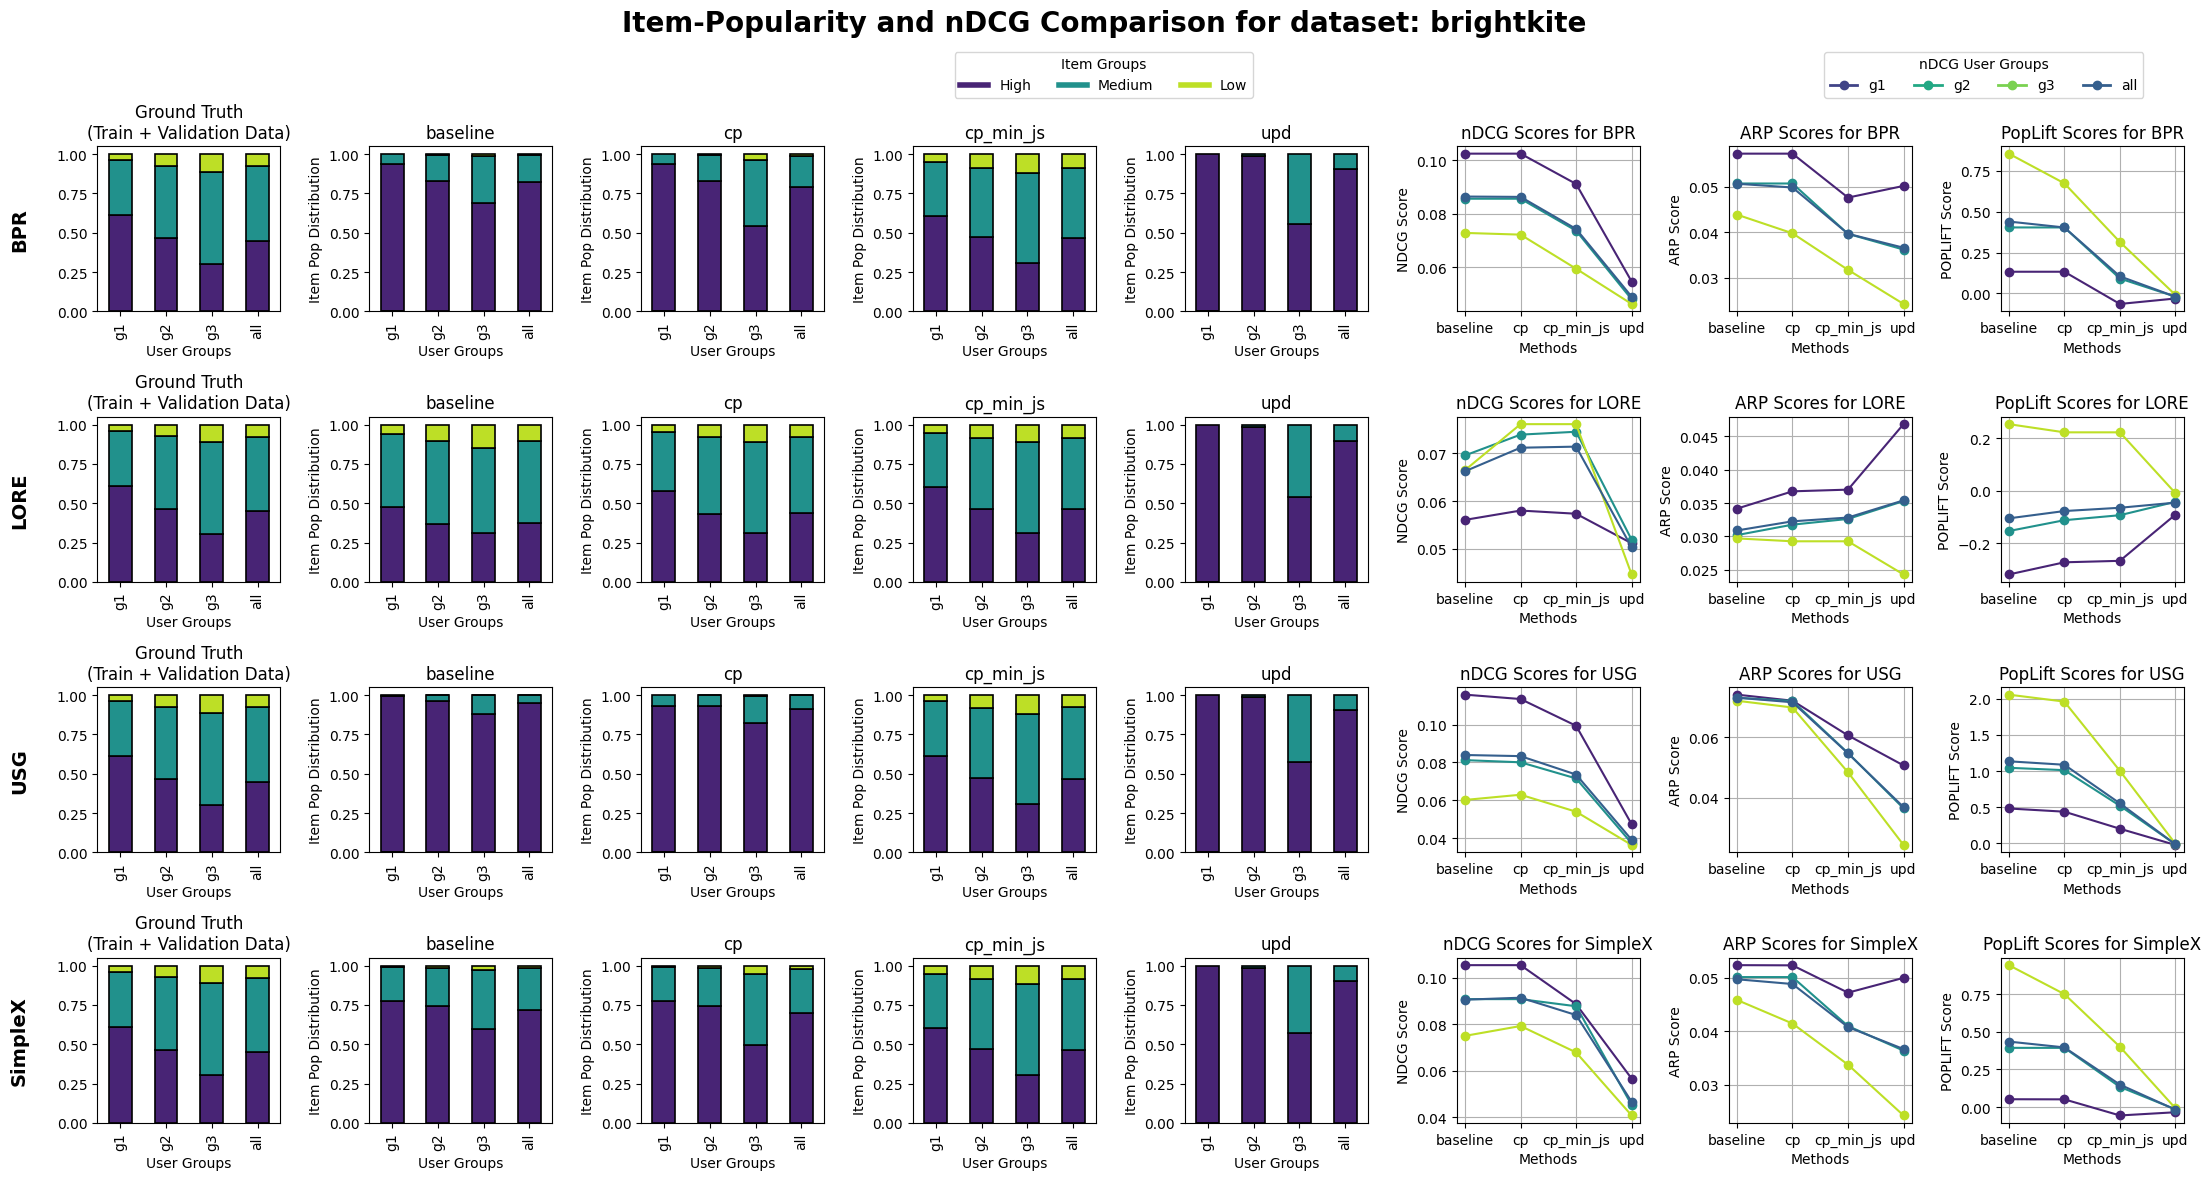

In [92]:
results = {}
fig, axs = plt.subplots(len(model_dirs), 8, figsize=(22, 12))  # Adjusted for nDCG plots

for i, (model_name, methods) in enumerate(model_dirs.items()):
    results[model_name] = {}

    # Plot the ground truth in the first column
    ax = axs[i, 0]
    plot_popularity_distribution(ax, ground_truth_distr, "Ground Truth\n(Train + Validation Data)")

    for j, (method_name, json_file) in enumerate(methods.items()):
        # with open(json_file, 'r') as f:
        #     eval_data = json.load(f)

        df = top_k_to_df(json_file)
        ndcg_scores = ndcg(df, test_data, top_k_eval)
        df_with_item_pop = df.merge(item_popularity, on="item_id:token", how="left")
        arp_scores, poplift_scores = calculate_arp_poplift(df_with_item_pop, item_popularity, upts, valid_popularity)

        group_eval = evaluation_user_group_means(ndcg_scores, arp_scores, poplift_scores, user_groups)
        results[model_name][method_name] = group_eval

        ax = axs[i, j + 1]
        distr_df = create_pop_distributions(df)
        plot_popularity_distribution(ax, distr_df, method_name)

    plot_line_chart(results, model_name, axs[i, -3], "ndcg", "nDCG Scores")
    plot_line_chart(results, model_name, axs[i, -2], "arp", "ARP Scores")
    plot_line_chart(results, model_name, axs[i, -1], "poplift", "PopLift Scores")

    axs[i, 0].set_ylabel(model_name, fontsize=14, weight='bold', labelpad=20)

fig.suptitle(f"Item-Popularity and nDCG Comparison for dataset: {dataset}", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in plt.cm.viridis([0.1, 0.5, 0.9])]
labels = ["High", "Medium", "Low"]
fig.legend(handles, labels, title="Item Groups", loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3)

ndcg_handles = [plt.Line2D([0], [0], color=color, lw=2, marker='o') for color in plt.cm.viridis([0.2, 0.6, 0.8, 0.3])]
ndcg_labels = ["g1", "g2", "g3", "all"]
fig.legend(ndcg_handles, ndcg_labels, title="nDCG User Groups", loc='upper center', bbox_to_anchor=(0.9, 0.95), ncol=4)

plt.savefig(f"{BASE_DIR}{dataset}_dataset/plots/item_popularity_and_ndcg_comparison.png")
print("Plots saved to 'item_popularity_and_ndcg_comparison.png'")

In [93]:
# Collect results into rows for CSV output
rows = []
for model_name, methods in results.items():
    for method_name, group_eval in methods.items():
        for group_name, metrics in group_eval.items():
            row = {
                'dataset': dataset,
                'model': model_name,
                'method': method_name,
                'user_group': group_name,
                'ndcg': metrics['ndcg_mean'],
                'arp': metrics['arp_mean'],
                'poplift': metrics['poplift_mean']
            }
            rows.append(row)

# Create a DataFrame from the rows
df_results = pd.DataFrame(rows)

# Save the evaluation results to a CSV file
df_results.to_csv(f'{BASE_DIR}/{dataset}_dataset/evaluation_results.csv', index=False)
# print("Evaluation results have been saved to 'evaluation_results.csv'")

In [94]:
df_results.tail(50)

,dataset,model,method,user_group,ndcg,arp,poplift
14,brightkite,BPR,upd,low,0.046203,0.024281,-0.008789
15,brightkite,BPR,upd,all,0.048938,0.036619,-0.019703
16,brightkite,LORE,baseline,high,0.056075,0.034160,-0.319187
17,brightkite,LORE,baseline,medium,0.069550,0.030185,-0.153545
18,brightkite,LORE,baseline,low,0.066480,0.029687,0.254351
19,brightkite,LORE,baseline,all,0.066241,0.030881,-0.105094
20,brightkite,LORE,cp,high,0.058022,0.036759,-0.272803
21,brightkite,LORE,cp,medium,0.073898,0.031754,-0.112167
22,brightkite,LORE,cp,low,0.076089,0.029256,0.223125
23,brightkite,LORE,cp,all,0.071161,0.032255,-0.077236


In [95]:

# 1. Best nDCG for each model and user group
best_ndcg_per_model_group = df_results.loc[df_results.groupby(['model', 'user_group'])['ndcg'].idxmax()]

# 2. Best overall nDCG for each user group
best_overall_ndcg_per_group = df_results.loc[df_results.groupby(['user_group'])['ndcg'].idxmax()]

# Display or save the results
print("Best nDCG for each model and user group:")
print(best_ndcg_per_model_group)

print("\nBest overall nDCG for each user group:")
print(best_overall_ndcg_per_group)


best_ndcg_per_model_group.to_csv(f'{BASE_DIR}/{dataset}_dataset/best_ndcg_per_model_group.csv', index=False)
best_overall_ndcg_per_group.to_csv(f'{BASE_DIR}/{dataset}_dataset/best_overall_ndcg_per_group.csv', index=False)

Best nDCG for each model and user group:
       dataset    model     method user_group      ndcg       arp   poplift
3   brightkite      BPR   baseline        all  0.086468  0.050650  0.439724
0   brightkite      BPR   baseline       high  0.102547  0.057253  0.132808
2   brightkite      BPR   baseline        low  0.072833  0.043878  0.854836
1   brightkite      BPR   baseline     medium  0.085653  0.050706  0.403658
27  brightkite     LORE  cp_min_js        all  0.071389  0.032822 -0.064696
20  brightkite     LORE         cp       high  0.058022  0.036759 -0.272803
22  brightkite     LORE         cp        low  0.076089  0.029256  0.223125
25  brightkite     LORE  cp_min_js     medium  0.074499  0.032613 -0.093133
55  brightkite  SimpleX         cp        all  0.091325  0.048837  0.396476
48  brightkite  SimpleX   baseline       high  0.105319  0.052362  0.051748
54  brightkite  SimpleX         cp        low  0.079159  0.041455  0.750963
49  brightkite  SimpleX   baseline     medium  

In [96]:
# Exposure Frequency PLot


# # List of algorithm DataFrames and their names
# algorithm_dfs = {
#     'BPR(Base)': base_df_general1,
#     'BPR(Re-ranked)': calibrated_df_general1,
#     'SimpleX(Re-ranked)': calibrated_df_general2,
#     'SimpleX(Base)': base_df_general2,
#     'LORE(Base)': base_df_context1,
#     'LORE(Re-ranked)': calibrated_df_context1,
#     'USG(Base)': base_df_context2,
#     'USG(Re-ranked)': calibrated_df_context2
# }

# # Dictionary to store sorted frequencies for each algorithm
# item_frequencies = {}

# # Calculate frequency of each item in recommendations for each algorithm
# for algorithm_name, df in algorithm_dfs.items():
#     # Count item frequencies in each DataFrame
#     item_counts = df['item_id:token'].value_counts(normalize=True)  # Normalize to get frequency
#     sorted_counts = item_counts.sort_values(ascending=True).values  # Sort in descending order
#     item_frequencies[algorithm_name] = sorted_counts  # Store sorted frequencies

# # Plotting
# plt.figure(figsize=(12, 6))

# # Plot each algorithm's sorted item frequencies
# for algorithm_name, frequencies in item_frequencies.items():
#     plt.plot(frequencies, label=algorithm_name)

# plt.xlabel('Items (sorted by frequency)')
# plt.ylabel('Recommendation Frequency')
# plt.title('Exposure Frequency of Items Recommended by Different Algorithms')
# plt.legend(title='Algorithms')
# plt.ylim(0, 0.045)  # Adjust as needed based on frequency range
# plt.xlim(0, 8000)  # Adjust as needed based on frequency range
# plt.show()
